# Breast Cancer Detection
You belong to the data team at a local research hospital. You've been tasked with developing a means to help doctors diagnose breast cancer. You've been given data about biopsied breast cells; where it is benign (not harmful) or malignant (cancerous).

- What features of a cell are the largest drivers of malignancy? 
- Build a model that predicts whether a given biopsied breast cell is benign or malignant.
- What features drive your false positive rate for your model you derived above, what features drive your false negative rate? 
- How would a physician use your product?
- There is a non-zero cost in time and money to collect each feature about a given cell. How would you go about determining the most cost-effective method of detecting malignancy?

## Data:

| Name | Range or Description |
| :- | :- |
| Sample code number | id number |
| Clump Thickness | 1-10 |
| Uniformity of Cell Size | 1-10 |
| Uniformity of Cell Shape | 1-10 |
| Marginal Adhesion | 1-10 |
| Single Epithelial Cell Size | 1-10 |
| Bare Nuclei | 1-10 |
| Bland Chromatin | 1-10 |
| Normal Nucleoli | 1-10 |
| Mitoses | 1-10 |
| Class | (4 for benign, 2 for malignant) |







In [20]:
# !pip install -U pandas numpy matplotlib seaborn scikit-learn imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline
plt.rcParams['font.size'] = 12
random_state = 5

# Dataset Information
Let's explore the dataset.

In [21]:
# Read the CSV file
df = pd.read_csv('breast-cancer-wisconsin.txt', sep=',', index_col='Index', header=0)
# Print few rows from dataframe
df

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Index,,,,,,,,,,,
0,1241035,7,8,3,7,4,5,7,8,2,4
1,1107684,6,10,5,5,4,10,6,10,1,4
2,691628,8,6,4,10,10,1,3,5,1,4
3,1226612,7,5,6,3,3,8,7,4,1,4
4,1142706,5,10,10,10,6,10,6,5,2,4
...,...,...,...,...,...,...,...,...,...,...,...
15850,1169049,7,3,4,4,3,3,3,2,7,4
15851,1076352,3,6,4,10,3,3,3,4,1,4
15852,1107684,6,10,5,5,4,10,6,10,1,4


# Check dataset information
Let's find non-standard items in the dataset (if any).

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15855 entries, 0 to 15854
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID                           15855 non-null  int64 
 1   Clump Thickness              15855 non-null  int64 
 2   Uniformity of Cell Size      15827 non-null  object
 3   Uniformity of Cell Shape     15827 non-null  object
 4   Marginal Adhesion            15827 non-null  object
 5   Single Epithelial Cell Size  15827 non-null  object
 6   Bare Nuclei                  15827 non-null  object
 7   Bland Chromatin              15827 non-null  object
 8   Normal Nucleoli              15827 non-null  object
 9   Mitoses                      15827 non-null  object
 10  Class                        15827 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.5+ MB


Although, the data is supposed to have only numerical values in the columns, some are interpreted as Objects. Let's find unwanted values in each column.

In [23]:
# Print unique values of each column
def print_unique(np_arr):
    for col in np_arr:
        print('Unique values in column "{}"":'. format(col))
        print(df[col].unique(),'\n')

# Print information about Object columns only (remove first two columns)
print_unique(np.delete(df.columns.values, [0,1], axis=0))

Unique values in column "Uniformity of Cell Size"":
['8' '10' '6' '5' '4' '9' '3' '1' 'No idea' '2' '7' '50' '100' '30' nan
 '#' '?' '80' '40' '60' '90' '20'] 

Unique values in column "Uniformity of Cell Shape"":
['3' '5' '4' '6' '10' '7' '1' 'No idea' '2' '60' '100' '40' nan '#' '9'
 '8' '?' '30' '50' '70'] 

Unique values in column "Marginal Adhesion"":
['7' '5' '10' '3' '6' '4' '1' '2' 'No idea' '30' '40' nan '#' '8' '?' '70'
 '60' '100' '50' '9' '20'] 

Unique values in column "Single Epithelial Cell Size"":
['4' '10' '3' '6' '2' '8' 'No idea' '1' '30' nan '5' '#' '?' '40' '20' '7'
 '60' '80' '100' '9'] 

Unique values in column "Bare Nuclei"":
['5' '10' '1' '8' '2' '3' '6' 'No idea' '?' '80' '60' '30' nan '100' '#'
 '9' '50' '7' '4' '20'] 

Unique values in column "Bland Chromatin"":
['7' '6' '3' '2' '4' 'No idea' '1' '5' '70' '30' nan '40' '#' '10' '8' '?'
 '20' '9' '60' '50'] 

Unique values in column "Normal Nucleoli"":
['8' '10' '5' '4' '3' '7' '2' '6' '9' '1' 'No idea' '40' 

OK! Let's replace \['No idea', '#', '?'\] with np.nan:

In [24]:
df = df.replace(['No idea', '#', '?'], np.nan)
print_unique(np.delete(df.columns.values, [0,1], axis=0))

Unique values in column "Uniformity of Cell Size"":
['8' '10' '6' '5' '4' '9' '3' '1' nan '2' '7' '50' '100' '30' '80' '40'
 '60' '90' '20'] 

Unique values in column "Uniformity of Cell Shape"":
['3' '5' '4' '6' '10' '7' '1' nan '2' '60' '100' '40' '9' '8' '30' '50'
 '70'] 

Unique values in column "Marginal Adhesion"":
['7' '5' '10' '3' '6' '4' '1' '2' nan '30' '40' '8' '70' '60' '100' '50'
 '9' '20'] 

Unique values in column "Single Epithelial Cell Size"":
['4' '10' '3' '6' '2' '8' nan '1' '30' '5' '40' '20' '7' '60' '80' '100'
 '9'] 

Unique values in column "Bare Nuclei"":
['5' '10' '1' '8' '2' '3' '6' nan '80' '60' '30' '100' '9' '50' '7' '4'
 '20'] 

Unique values in column "Bland Chromatin"":
['7' '6' '3' '2' '4' nan '1' '5' '70' '30' '40' '10' '8' '20' '9' '60'
 '50'] 

Unique values in column "Normal Nucleoli"":
['8' '10' '5' '4' '3' '7' '2' '6' '9' '1' nan '40' '90' '20' '30' '80'
 '60' '50' '100' '70'] 

Unique values in column "Mitoses"":
['2' '1' '7' nan '3' '10' '70' '8

The dataset looks much better already! Now, we remove nan values and change column types to numeric and check the Class column value counts and convert 20 and 40 to 2 and 4!

In [25]:
df = df.dropna()
df= df.apply(pd.to_numeric)
df = df[df['Class'] != 20]
df = df[df['Class'] != 40]
# df['Class'] = df['Class'].replace(20, 2)
# df['Class'] = df['Class'].replace(40, 4)
df['Class']=df['Class'].astype('category')
df['Class'].value_counts()


4    15162
2      442
Name: Class, dtype: int64

# Explatory Data Analysis

Let's plot the columns in the data frame against each other. 

[Text(0.5, 0, 'Clump Thickness'),
 Text(1.5, 0, 'Uniformity of Cell Size'),
 Text(2.5, 0, 'Uniformity of Cell Shape'),
 Text(3.5, 0, 'Marginal Adhesion'),
 Text(4.5, 0, 'Single Epithelial Cell Size'),
 Text(5.5, 0, 'Bare Nuclei'),
 Text(6.5, 0, 'Bland Chromatin'),
 Text(7.5, 0, 'Normal Nucleoli'),
 Text(8.5, 0, 'Mitoses')]

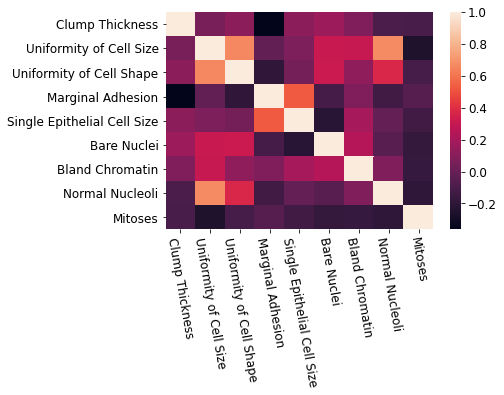

In [50]:
corr = df.loc[:, ~df.columns.isin(['ID'])].corr()
ax = sns.heatmap(corr)
ax.set_xticklabels(g.get_xticklabels(), rotation = -80)

# Classification

Let's divide the dataset to train and test sets and find the null accuracy showing the expectecd accuracy if a model always predicts the majority class.

In [27]:
X = df.loc[:, ~df.columns.isin(['ID', 'Class'])]
y = df['Class'] 
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=random_state)
print('Null accuracy: {}'.format(y_test.value_counts()[4]/y_test.shape[0]))
class_name_dict={2:'malignant', 4:'benign'}

Null accuracy: 0.9723147910792105


In [28]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state)
print('Average ROC AUC for CV: {}'.format(
        cross_val_score(clf, X, y, cv=5, scoring = 'roc_auc', n_jobs=-1).mean()))
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print('ROC AUC: {}'.format(roc_auc))
print('Confusion Matrix:\n{}'.format(cm))

Average ROC AUC for CV: 0.9999032748800671
              precision    recall  f1-score   support

           2       0.96      0.99      0.98       108
           4       1.00      1.00      1.00      3793

    accuracy                           1.00      3901
   macro avg       0.98      0.99      0.99      3901
weighted avg       1.00      1.00      1.00      3901

ROC AUC: 0.99484308326254
Confusion Matrix:
[[ 107    1]
 [   4 3789]]


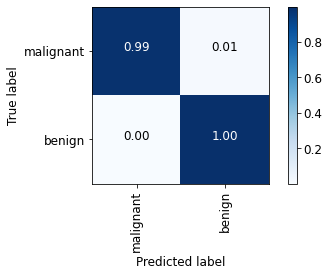

In [35]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
labels = np.unique(y).tolist()
labels = [class_name_dict.get(item, item)  for item in labels]
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

Text(0, 0.5, 'Frequency')

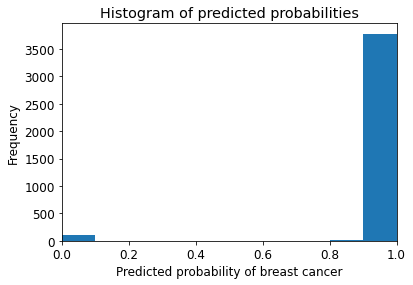

In [30]:
y_prob = clf.predict_proba(X_test)[:, 1]
plt.hist(y_prob, bins=10)
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of breast cancer')
plt.ylabel('Frequency')

Most of observasions have more than 90% probability to predict breast cancer. Let's look at the roc curve:

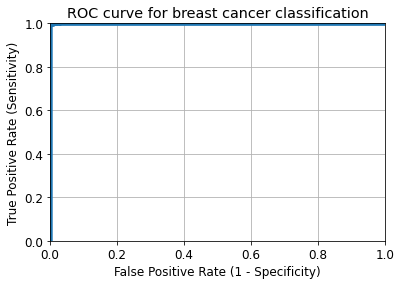

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob,  pos_label=4 )
plt.plot(fpr, tpr, linewidth=5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for breast cancer classification')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# Feature Importance
Let's find out which features drive our classification more than others.

Clump Thickness                0.106960
Uniformity of Cell Size        0.372293
Uniformity of Cell Shape       0.297769
Marginal Adhesion              0.032526
Single Epithelial Cell Size    0.038511
Bare Nuclei                    0.044636
Bland Chromatin                0.084517
Normal Nucleoli                0.018277
Mitoses                        0.004512
dtype: float64


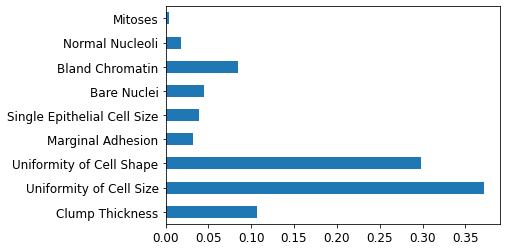

In [32]:
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.plot(kind='barh')
print(importances)

Let's use only the first 3 important features.

In [33]:
X = df.loc[:, df.columns.isin(['Uniformity of Cell Size',
                            'Uniformity of Cell Shape'])]
y = df['Class'] 
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=random_state)
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state)
print('Average ROC AUC for CV: {}'.format(
        cross_val_score(clf, X, y, cv=5, scoring = 'roc_auc', n_jobs=-1).mean()))
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
cm_1 = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print('ROC AUC: {}'.format(roc_auc))
print('Confusion Matrix:\n{}'.format(cm_1))

Average ROC AUC for CV: 0.9933430012011486
              precision    recall  f1-score   support

           2       0.95      0.97      0.96       108
           4       1.00      1.00      1.00      3793

    accuracy                           1.00      3901
   macro avg       0.98      0.99      0.98      3901
weighted avg       1.00      1.00      1.00      3901

ROC AUC: 0.9854520022263232
Confusion Matrix:
[[ 105    3]
 [   5 3788]]


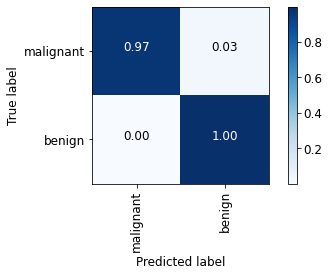

In [36]:
plt.imshow(cm_1, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
labels = np.unique(y).tolist()
labels = [class_name_dict.get(item, item)  for item in labels]
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
cm_1 = cm_1.astype('float') / cm_1.sum(axis=1)[:, np.newaxis]
thresh = cm_1.max() / 2.
for i, j in itertools.product(range(cm_1.shape[0]), range(cm_1.shape[1])):
    plt.text(j, i, format(cm_1[i, j], '.2f'),
                horizontalalignment="center",
                color="white" if cm_1[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

To reduce the cost, the doctors can predict most of cancers using only 'Uniformity of Cell Size' and 'Uniformity of Cell Shape'.